## 필수 패키지 로드 
만약 package 가 없다는 에러가 발생하면 pip install 명령어로 설치하면 된다. 아마 miniconda 를 설치했다면 아래 페키지가 한개도 없을 가능성이 크기 때문에
pip install torch pandas matplotlib torchvision torchinfo torch_lightning 등을 다 해줘야 함!

In [6]:
!pip install pytorch_lightning torchinfo

In [7]:
import torch
torch.__version__

'2.3.1+cu121'

In [8]:
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim

import pytorch_lightning as pl
from pytorch_lightning.accelerators import accelerator
from torchmetrics import functional as FM
from torchinfo import summary

from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 3.5]
plt.rcParams["font.size"] = "8"

torch.__version__,pl.__version__,

('2.3.1+cu121', '2.3.1')

## Dataset 준비


뭐니뭐니 해도 가장 기본적인 데이터는 국민 딥러닝 데이터인 손글씨 (MNIST) 일 것이다. 데이터에 대해서 잠시 설명하자면 28x28 pixel 사이즈로 쓰여진 손 글씨를 흑백 파일로 만든 것이다.
흑백이기 때문에 RGB 이미지와 달리 채널은 1개뿐이고, 사이즈는 28 x 28 로 이루어져 있다.

In [9]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def dataLoader(batch_size=128):
    train_dataset = MNIST('', transform=transforms.ToTensor(), train=True, download=True) ## 한 번 인터넷으로 가져온걸 매번 가져올 필요가 없기 때문에 가져올때 download True 로 하면 다음 부터는 다운로드 된 데이터를 사용한다.
    test_dataset = MNIST('', transform=transforms.ToTensor(), train=False, download=True)
    trainDataLoader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valDataLoader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return (trainDataLoader,valDataLoader)

trainDataLoader,valDataLoader = dataLoader()

- transforms : pytorch 는 Tensor 라는 데이터 형을 사용하기 때문에 (numpy의 ndarray 와 비슷하지만 추가 정보가 포함되어있어서 좀 더 고차원인 데이터형식) 아예 데이터를 받으면서 tensor 형으로 변환시켜주었다.
- download : 인터넷에서 데이터를 로드 할 때, 매번 로드할 필요없이 다운로드를 받아두면 그 다음부터는 다운로드 받은 데이터를 사용하기 때문에 속도와 네트워크 사용량에서 유리하다

받아진 데이터를 쉽게 핸들링하기 위해서 바로 DataLoader 에 셋업하였다. DataLoader 에 로딩된 데이터는 간단히 next(iter()) 를 통해서 데이터를 받아오고 다음으로 넘어갈 수 있다. 파이토치를 쓸 때 가장 편한 유틸이 바로 이 데이터 셋을 만들고 이걸 로더에 로딩만하면 데이터를 학습할때 굳이 데이터 위치를 일일이 설정해줄 필요가 없다는 점이다.

In [10]:
train_data = MNIST('', transform=transforms.ToTensor(), train=True, download=True)

In [11]:
print(train_data) ## 6만개의 손글씨 데이터 셋
#train_data[0] ## 중에서 첫번째  (이미지 + 라벨)
#train_data[0][0] ## 중에서 이미지

Dataset MNIST
    Number of datapoints: 60000
    Root location: 
    Split: Train
    StandardTransform
Transform: ToTensor()


torch.Size([1, 28, 28])
5


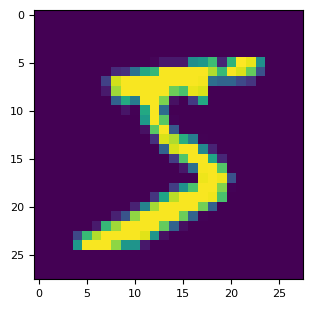

In [12]:
print(train_data[0][0].shape)
plt.imshow(train_data[0][0].view((28,28))) ##  tensor 에서는 reshape 대신 view 를 쓴다. 물론 reshape 도 되기는 하는데, 전통적으로 view 를 더 많이 쓰는듯.
print( train_data[0][1] )

###  Model 정의 

이제 데이터가 준비되었으니, 아주 간단한 모델을 만들어보자. 모델이 할 일은 다음과 같다. 

1. 손글씨 데이터를 읽어서
2. 28 * 28 을 기다란 784 vector 로 만든 뒤에
3. Fully connected 된 1개의 layer를 통해서
4. 0~10 을 예측하는 layer로 전달하고 
5. 이걸 onehot encode 된 실제 y와 비교하여
6. loss 를 계산하여, 이 loss가 최소가 되도록!

   

In [13]:
loss_function = nn.CrossEntropyLoss() ## 회귀가 아닌 분류의 문제이므로 cross entropy 를 loss 로 사용한다. 

class mymodel1( pl.LightningModule ):  ## torch 또는 torch_lightning 의 기본 모듈을 상속받아서 사용한다. torch_lightning 이 좀 더 편하므로 왠만하면 lihgtning 을 상속
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(  ## forward 에서 이리저리 연결해주는 방법보다. 그냥 순차적인 layer 하나 넣주는게 여러모로 편함.
            nn.Flatten(),
            nn.Linear( 28*28, 10 ),
        )

    def forward(self, x):
        out = self.layers(x)
        return out



이렇게 기본적인 뼈대가 만들어졌다. 물론 아직 이대로는 돌아가지 않는다. torch_lightning 은 보통 Trainer 를 통해서 학습하게 되는데, Trainer 에 물리기 위해서는 다음의 매쏘드가 정의되어야 한다.

1. training_step : 학습을 진행할 때 (~ train loop 에서 하는 일)
2. validation_step : 검증을 진행할 때 (위와 같지만 굳이 loss return 필요없음)
3. test_step : 테스트를 진행할 때 (위와 같고 역시 loss retrun 필요없음)
4. configure_optimizer : 옵티마이져에 대한 셋팅

이것만 정의하면 되고, 굳이 torch 에서 처럼 x.to(device), x.cuda() 이런거는 다 자동으로 이루어진다! (세상에!)
심지어 학습만 하고 검증/예측을 안할꺼라면 그냥 1, 4만 구현해도 된다.

그래도 검증까지는 필요하니까 train을 정의하고 optimizer 를 정의해서 모델을 완료시킨다.

In [14]:

class mymodel2( mymodel1 ): 

        
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [15]:

mm = mymodel2()
summary(mm, input_size = (1, 1, 28, 28)) ## 들어갈때 batch size와 channel 을 알려줘야함

Layer (type:depth-idx)                   Output Shape              Param #
mymodel2                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 10]                   7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

이대로도 학습은 잘 진행된다. 3회만 학습을 돌려보자.

In [17]:
%%time
epochs = 3
trainer = pl.Trainer(max_epochs=epochs,accelerator="gpu")
trainer.fit(mm, trainDataLoader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | Sequential | 7.9 K  | train
----------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


CPU times: total: 1.61 s
Wall time: 12.7 s
